In [34]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Chargement des données
df = pd.read_csv("Data/Etude sur les Français et l_Information/les-francais-et-l-information-propre.csv")

# Chargement des questions
with open("Data/Etude sur les Français et l_Information/questionnaire.json", "r") as f:
    questionnaire = json.load(f)


C:\Users\totog\AppData\Local\Temp\ipykernel_9244\3238581139.py:2: DtypeWarning: Columns (16,20,104,105,111,112,113,120,121,128,129,136,137,145,152,153,234,264,265,279,280,281,282,296,305,316,317,318,330,342,343,344) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/Etude sur les Français et l_Information/les-francais-et-l-information-propre.csv")


## Premier modèle: Prédire le vote avec les chaines TV 1 à 12.

On refait un peu de nettoyage des données, suppression des NaN est one-hot encoding pour les catégories de la variable à prédire.

In [62]:
# Variables prédictives
liste_col = [col for col in df.columns if col.startswith("SOURCES1DR_B4_R")]
liste_col += [col for col in df.columns if col.startswith("SOURCES1ER_B4_R")]
X_brut = df[liste_col]

# Variable à prédire 
y = df["PP3_R"]

# Supression des nan
print("Avant suppression des nan: ")
print("Taille de X: ", X_brut.shape)
print("Taille de y: ", y.shape)

condition_X = X_brut.isna().all(axis=1)
condition_y_1 = y.isna() | (y == "Je ne suis pas inscrit sur les listes électorales")
condition_y_2 = (y == "Je ne suis pas inscrit·e sur les listes électorales") | (y=="Non réponse")

indices_nan = df.index[condition_X | condition_y_1 | condition_y_2]
X_brut = X_brut.drop(index = indices_nan)
y = y.drop(index = indices_nan)

print("\nAprès suppression des nan: ")
print("Taille de X: ", X_brut.shape)
print("Taille de y: ", y.shape)

# Liste des chaîne de TV
liste_valeurs_avec_nan= pd.unique(X_brut.values.ravel())
liste_valeurs = [val for val in liste_valeurs_avec_nan if not pd.isna(val)]

# Initialiser un DataFrame avec une colonne par chaîne et des zéros
X = pd.DataFrame(0, index=X_brut.index, columns=liste_valeurs)

# Remplir le DataFrame final
for i, row in X_brut.iterrows():
    # Extraire les réponses non NaN de la ligne courante
    reponses = row.dropna().unique().tolist()
    # Mettre 1 dans les colonnes correspondantes aux réponses
    X.loc[i, reponses] = 1

# Vérification de la cohérence des données
"""condition = X.apply(
    lambda row: (row['Rien de tout cela'] == 0) or (row['Rien de tout cela'] == 1 and (row.drop('Rien de tout cela') == 0).all()),
    axis=1
)
if not condition.all():
    print("\nDONNÉES INCOHÉRENTES")"""
    
# Suppression de la colonne donnant une information redondante
"""else:"""
X = X.drop(columns=['Rien de tout cela'])

X

Avant suppression des nan: 
Taille de X:  (3346, 22)
Taille de y:  (3346,)

Après suppression des nan: 
Taille de X:  (2688, 22)
Taille de y:  (2688,)


,France 2,Arte,Non cité,Une autre chaîne TV généraliste,TF1,France 3,BFM TV,CNews,M6,C8,TMC,France 5,France24,LCI,Franceinfo la chaîne de TV,Canal+,RMC Story,"Chaînes d'information internationale (Al Jazeera, CNN, BBC etc..)",Une autre chaîne d’information internationale,Une chaîne de TV locale
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0
3341,0,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0
3342,1,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1
3344,1,0,0,0,1,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0


In [63]:
X.isna().any()

France 2                                                             False
Arte                                                                 False
Non cité                                                             False
Une autre chaîne TV généraliste                                      False
TF1                                                                  False
France 3                                                             False
BFM TV                                                               False
CNews                                                                False
M6                                                                   False
C8                                                                   False
TMC                                                                  False
France 5                                                             False
France24                                                             False
LCI                      

Voici quelques statistiques descriptives sur les données

   France 2  Arte  Non cité  Une autre chaîne TV généraliste   TF1  France 3  \
0      1616  1926      2639                             2582  1272      1813   
1      1072   762        49                              106  1416       875   

   BFM TV  CNews    M6    C8   TMC  France 5  France24   LCI  \
0    1629   1921  1529  2209  2255      2081      2318  2009   
1    1059    767  1159   479   433       607       370   679   

   Franceinfo la chaîne de TV  Canal+  RMC Story  \
0                        2162    2329       2335   
1                         526     359        353   

   Chaînes d'information internationale (Al Jazeera, CNN, BBC etc..)  \
0                                               2597                   
1                                                 91                   

   Une autre chaîne d’information internationale  Une chaîne de TV locale  
0                                           2648                     2646  
1                                       

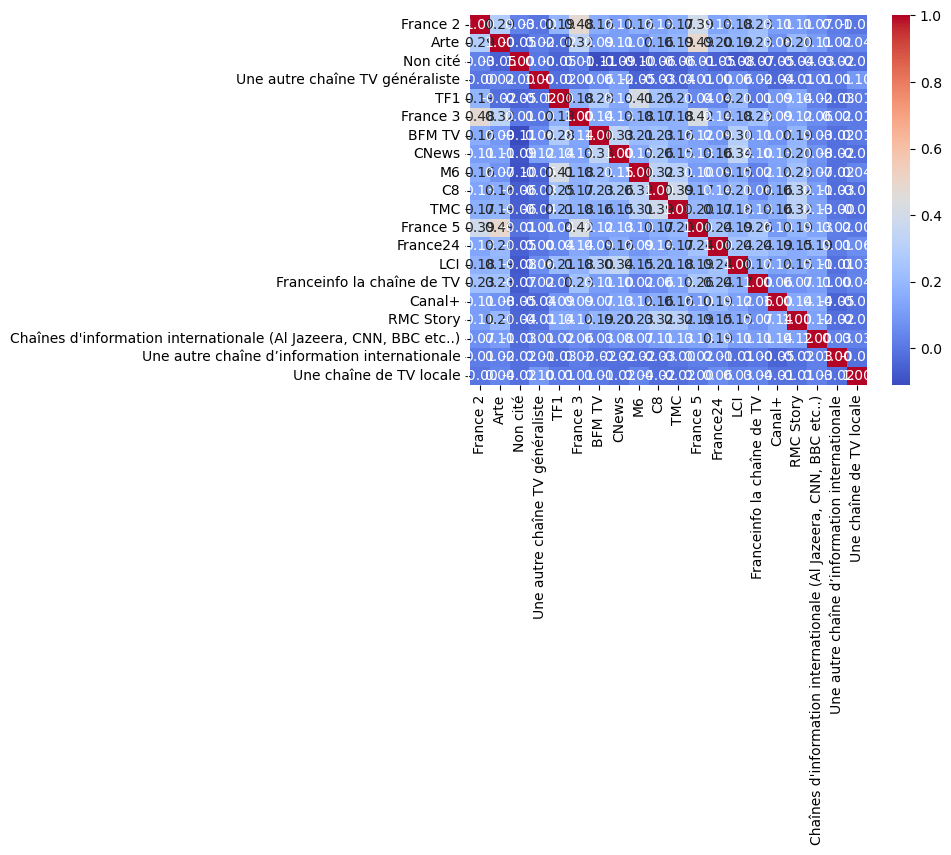

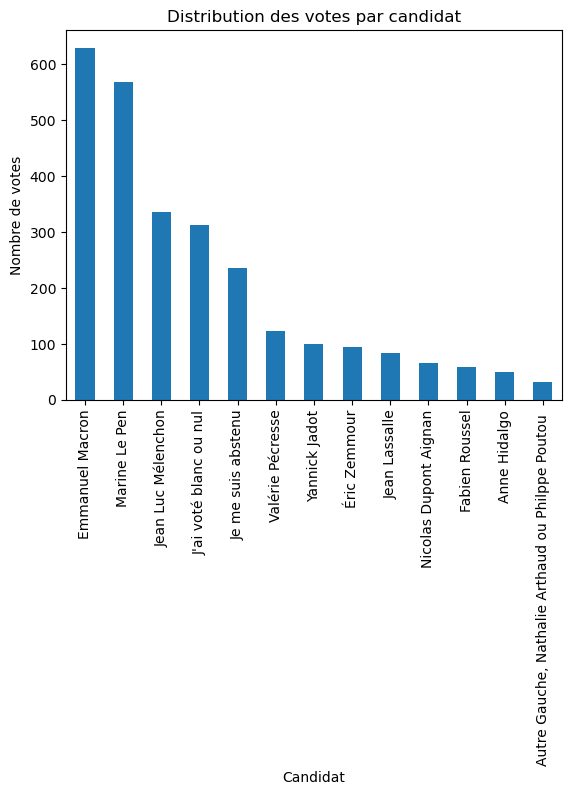

In [64]:
print(X.apply(pd.Series.value_counts))  # Comptage des valeurs (0 et 1) pour chaque colonn

correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

y.value_counts().plot(kind='bar')
plt.xlabel('Candidat')
plt.ylabel('Nombre de votes')
plt.title('Distribution des votes par candidat')
plt.show()

In [39]:
import scipy.stats as stats

# Liste des résultats p-values de l'ANOVA
p_values = []

# Boucle sur chaque colonne de X
for column in X.columns:
    # Créer les groupes pour l'ANOVA : chaque groupe correspond aux valeurs de la colonne 'column' pour chaque candidat
    groups = [X[column][y == candidate] for candidate in y.unique()]
    
    # Effectuer le test ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    # Ajouter la p-value à la liste
    p_values.append((column, p_value))

# Convertir les résultats en DataFrame pour faciliter la lecture
anova_results = pd.DataFrame(p_values, columns=["Variable", "p-value"])

# Afficher les résultats de l'ANOVA
print(anova_results)


                           Variable       p-value
0                               TF1  4.683201e-07
1                          France 2  3.728533e-14
2                              Arte  6.757924e-18
3   Une autre chaîne TV généraliste  8.339927e-08
4                          France 3  2.020495e-09
5                                M6  2.558518e-04
6                                C8  8.210141e-03
7                               TMC  2.442480e-01
8                          France 5  6.797480e-15
9                            Canal+  1.142059e-03
10                        RMC Story  1.886071e-01
11          Une chaîne de TV locale  2.671644e-01


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialiser et entraîner le modèle Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédire les valeurs de y sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2f}")


Accuracy : 0.23


In [66]:
from sklearn.svm import SVC

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialiser et entraîner le modèle Random Forest
model = SVC()
model.fit(X_train, y_train)

# Prédire les valeurs de y sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2f}")

Accuracy : 0.28


In [67]:
from sklearn.linear_model import LogisticRegression

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialiser et entraîner le modèle Random Forest
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédire les valeurs de y sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2f}")

Accuracy : 0.30


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Préparation des données
X = X.values  # Convertir en numpy array si ce n'est pas déjà le cas
y = y.values  # Idem pour y

# Encoder y si c'est une variable catégorielle (par exemple, les candidats)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encoder les labels en entiers

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convertir en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Définir le modèle de réseau de neurones dense
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Première couche
        self.fc2 = nn.Linear(64, 32)          # Deuxième couche
        self.fc3 = nn.Linear(32, output_size) # Couche de sortie
        self.relu = nn.ReLU()                 # Fonction d'activation ReLU
        self.softmax = nn.Softmax(dim=1)      # Activation softmax pour multi-classes

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Initialiser le modèle
input_size = X_train.shape[1]  # Nombre de features (chaînes TV)
output_size = len(np.unique(y))  # Nombre de classes (candidats)
model = NeuralNetwork(input_size, output_size)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()  # Pour la classification multi-classes
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass et optimisation
    optimizer.zero_grad()  # Remise à zéro des gradients
    loss.backward()        # Calcul des gradients
    optimizer.step()       # Mise à jour des poids

    # Afficher la perte tous les 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Évaluer le modèle sur l'ensemble de test
with torch.no_grad():
    model.eval()  # Mode évaluation
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')


Epoch [100/1000], Loss: 2.4100
Epoch [200/1000], Loss: 2.3817
Epoch [300/1000], Loss: 2.3739
Epoch [400/1000], Loss: 2.3659
Epoch [500/1000], Loss: 2.3575
Epoch [600/1000], Loss: 2.3524
Epoch [700/1000], Loss: 2.3492
Epoch [800/1000], Loss: 2.3471
Epoch [900/1000], Loss: 2.3383
Epoch [1000/1000], Loss: 2.3332
Accuracy on test set: 28.25%
